The Cayula-Cornillon algorithm relies on a combination of methods and it operates at the picture, the window, and the local level. The resulting edge is not based on the absolute strenght of the front, but on the relative strenght depending on the context, thus making the edge detection temperature-scale invariant.

The algorithm deals with both cloud and edge detection


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import matplotlib
plt.rcParams["figure.figsize"] = 14, 12
%matplotlib inline

### Load Data

In [2]:
def get_data(data):
    
    """
    function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #caso se esteja a importar os dados do MUR, renomear as colunas e passar a temperatura para Celsius
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [3]:
df_mur_aug = get_data('murAugust2019.nc')

In [4]:
df_mur_aug

,latitude,longitude,time,thetao
0,35.0,-19.0,2019-08-01 09:00:00,22.830994
1,35.0,-19.0,2019-08-02 09:00:00,23.727997
2,35.0,-19.0,2019-08-03 09:00:00,24.345001
3,35.0,-19.0,2019-08-04 09:00:00,24.382996
4,35.0,-19.0,2019-08-05 09:00:00,24.256012
...,...,...,...,...
43474426,45.0,-5.0,2019-08-27 09:00:00,19.819000
43474427,45.0,-5.0,2019-08-28 09:00:00,20.588013
43474428,45.0,-5.0,2019-08-29 09:00:00,20.716003
43474429,45.0,-5.0,2019-08-30 09:00:00,20.743988


In [5]:
#Importar o netCDF dos dados de reanalise e converte-los para uma dataframe
df_reanalysis = get_data('IBI2014-2019.nc')

In [6]:
df_reanalysis

,latitude,longitude,time,thetao
0,35.0,-19.0,2014-01-01 12:00:00,18.316000
1,35.0,-19.0,2014-01-02 12:00:00,18.309000
2,35.0,-19.0,2014-01-03 12:00:00,18.316000
3,35.0,-19.0,2014-01-04 12:00:00,18.273001
4,35.0,-19.0,2014-01-05 12:00:00,18.230000
...,...,...,...,...
44660611,45.0,-5.0,2019-12-20 12:00:00,13.619000
44660612,45.0,-5.0,2019-12-21 12:00:00,13.559000
44660613,45.0,-5.0,2019-12-22 12:00:00,13.458000
44660614,45.0,-5.0,2019-12-23 12:00:00,13.400000


In [7]:
Aug1_rean = df_reanalysis[df_reanalysis['time'] == '2019-08-01 12:00:00']

In [8]:
#Sacar dados do MUR para um só dia para testar o algoritmo Cayulla-Cornillon no MATLAB e Python
Aug1_mur = df_mur_aug[df_mur_aug['time'] == '2019-08-01 09:00:00']

In [26]:
lat = Aug1_mur['latitude'].to_numpy()
lon = Aug1_mur['longitude'].to_numpy()

In [27]:
lat = np.unique(lat).round(3)
lon = np.unique(lon).round(3)
sst = Aug1_mur.pivot_table(index='longitude', columns='latitude', values='thetao').values.round(4)

## Cayula-Cornillon 

In [28]:
lat_min = lat.min()     
lat_max = lat.max()
lon_min = lon.min()
lon_max = lon.max()

lat_unique = len(np.unique(lat))    # nr of different latitude points
lon_unique = len(np.unique(lon))    #nr of different longitude points


In [29]:
X = np.linspace(lon_min, lon_max, lon_unique)        #linearly spaced vector with the longitude points
Y = np.linspace(lat_min, lat_max, lat_unique)        #linearly spaced vector with the latitude points
X, Y = np.meshgrid(X, Y)                 #create a rectangular grid out of two given one-dimensional arrays

lat, lon = np.meshgrid(lat, lon)            

from scipy.interpolate import griddata
Z = griddata((lon.flatten(), lat.flatten()), sst.flatten(), (X,Y), method='linear')   

In [30]:
head = np.array([lon_min, lon_max])           #Extremos do array que se obtem com a meshgrid em X
head = np.append(head, [lat_min, lat_max])   #Extremos do array que se obtem com a meshgrid em Y

z_dim = Z.shape    #dimensões da matriz Z (rows, cols)

z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])    #range dos dados (valor minimo e maximo da matriz Z)
nx = z_dim[1]      # number of columns of matrix Z
ny = z_dim[0]      # number of rows of matrix Z
node_offset = 0
    
#index 4 -> menor valor de Z; index5 -> maior valor de Z; index6 -> node_offset=0
head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     #index 7 -> quociente da diferença dos extremos da meshgrid em X e o nr de colunas-1
head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     #index 8 -> quociente da diferença dos extremos da meshgrid em Y e o nr de rows-1
head = head.astype('float')

In [31]:
################################# 

# Window size 32 × 32

# Window clarity (% of data have to present in the window) 75%
# Overlap 50%

# The ratio of variance between the two populations to the
# variance within the populations θ(τopt )% 0.76

# Gradient ratio 0.9

# Cohesion coefficients [C1, C2, C] [0.9, 0.9, 0.92]
# Mean temperature difference between the two populations (surface waters)
# .25

#cayula
minPopProp = 0.20        #minimum proportion of each population
minPopMeanDiff = 0.4     # minimum difference between the means of the 2 populations
minTheta = 0.70
minSinglePopCohesion = 0.90
minGlobalPopCohesion = 0.70

#nieto
#minPopProp = 0.15
#minPopMeanDiff = 0.4
#minTheta = 0.70
#minSinglePopCohesion = 0.90
#minGlobalPopCohesion = 0.70

##################################

In [32]:
def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    #empty arrays de xdata, ydata e z
    xdata = np.array([])
    ydata = np.array([])
    z = np.array([])
    exitType=0
    
    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 if mask has 1s (that correspond to NaNs in matrix w)
    n_NaNs=0
    
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])       # count nr of 1s (NaNs in matrix w) that there are
        if (n_NaNs/len(w.flatten())>0.5):     #window can't have more than 50% of its pixels as NaNs
            exitType=-1
            return None,None,None,exitType  
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]                          #array with minimum and maximum value of w
    n = math.ceil((mi_ma[1]-mi_ma[0])/0.02)                       #number of bins
    bins = np.arange(mi_ma[0], mi_ma[1], 0.02)                    #to define the bins sequence 
    [y, xout] = np.histogram(w[:], bins, mi_ma)                   #y->frequency counts, Xout->bin location
    xout = np.mean(np.vstack([xout[0:-1],xout[1:]]), axis=0)     #xout to be relative to the centers of the bins
    
    
    thresValue = xout[0]        
    totalCount = len(w.flatten()) - n_NaNs    #nr of non NaN pixels 
    threshPopACount = 0
    threshSeparation = -1
    threshPopAMean = 0
    threshPopBMean = 0
    
    w[mask==1] = 0                      #Replace NaNs with 0's (when mask is 1 replace values of array w for 0)
    totalSum = sum(w.flatten())                      #sum of values of matrix w
    totalSumSquares = sum(w.flatten()*w.flatten())   #sum of the squares of the values of w
    
    #In this for loop we are going to discover which line is going to make the best separation between the average
    # of population on the left and on the right (A and B) - and that is going to be the thresValue
    for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k+1] * xout[0:k+1])    
        popBSum = sum(y[k+1:] * xout[k+1:])  
        popACount = sum(y[0:k+1])     #sum of frequencies (y) from populationA
        popBCount = sum(y[k+1:])      #sum of frequencies (y) from populationB
    
        popAMean = popASum/popACount
        try:                                  #try to avoid the zerodivisionerror that was poping up 
            popBMean = popBSum/popBCount
        except ZeroDivisionError:
            popBMean = 0
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
         
        #abort in case the proportion of population A is less that a certain minimum
    if (threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None,None,exitType  
    
    #abort in case the proportion of population B is less that a certain minimum
    if (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None,None,exitType  
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):   
        exitType = 2
        return None,None,None,exitType  
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abort if theta is lower than a certain minimum  
        exitType = 3
        return None,None,None,exitType  
    
#Cohesion - now that we know the separation value. Based on this value we will check the matrix element by 
#element, and check whether is bigger or lower than the separation  
#we check if it's bigger bellow or to the right (when its bigger we add from one side, when its lower add to the other)
#Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
# A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
#redundant. Do not count diagonal neighbors
    countANextToA = 0
    countBNextToB = 0
    countANextToAOrB = 0
    countBNextToAOrB = 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):                  #if matrix pixel < than the element of separation
                countANextToAOrB = countANextToAOrB + 1      #increase by 1 countANextToAOrB
                if (w[row+1, col] <= thresValue):            #if pixel of bottom row < than separation
                    countANextToA = countANextToA + 1        #increase countANextToA
            else:                                            #if pixel > than separation 
                countBNextToAOrB = countBNextToAOrB + 1      #increase countBNextToAOrB
                if (w[row+1, col] > thresValue):             #if pixel of bellow row > separation
                    countBNextToB = countBNextToB + 1        #increase countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     #if matrix pixel < separation      
                countANextToAOrB = countANextToAOrB + 1         # increase countANextToAOrB
                if (w[row, col+1] <= thresValue):               #if right pixel < separation
                    countANextToA = countANextToA + 1           # increase countANextToA
            else:                                               #if matrix pixel > separation
                countBNextToAOrB = countBNextToAOrB + 1         #increase countBNextToAOrB
                if (w[row, col+1] > thresValue):                #if right pixel > separation
                    countBNextToB = countBNextToB +1            # increase countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBCohesion = countBNextToB/ countBNextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #These ifs are in case of errors (parameters below certain limits)
    if (popACohesion < minSinglePopCohesion):
        exitType = 4
        return None,None,None,exitType  
                         
    if (popBCohesion < minSinglePopCohesion):
        exitType = 4
        return None,None,None,exitType  
                         
    if (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return None,None,None,exitType  
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, [thresValue])   #Create and store a set of contour lines or filled regions.
    else:
        #the 4 corners have these indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        
        X = X[np.arange(corners[2]-1, corners[3])]
        Y = Y[np.arange(corners[0]-1, corners[1])]
        w = w[np.arange(corners[0], corners[1]).min()-1:np.arange(corners[0], corners[1]).max()+1, np.arange(corners[2], corners[3]).min()-1:np.arange(corners[2], corners[3]).max()+1]
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (np.isnan(w)).all()==True:
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, [thresValue])   #Create and store a set of contour lines or filled regions.
                     
                
        
        M = c.allsegs[:]          #list of arrays for contour c. Each array corresponds to a line that may or may
                                    #not be drawn. This list can have any number of arrays
            
        M = [x for x in M if x]   #if the list has empty arrays we will drop them
        
        count = 0   #to iterate through the various arrays
        
        #Create list of booleans (True or False) wether the conditions bellow are fulfilled
        # Each array (line of contour) must have more that 7 data points and they can't be closed lines
        lista = []     
        for i in range(len(M[:])):
            lista.append([(len(x)<7 or (x[0][0]==x[-1][0] and x[0][1] == x[-1][1])) for x in M[:][i]])
            
            #if False the line will be drawn
            #if True the line will be ignored
            
        for value in lista:
            if value == [True]:
                continue        #return to the top of the for loop
            else:
        
                #For the first array of M we will take all the values of x and put them into an array
                x = []
                for i in range(len(M[:][count][0])):
                    x.append((M[:][count][0][i][0]).round(4))
                
                #For the first array of M we will take all the values of y and put them into an array
                y = []
                for i in range(len(M[:][count][0])):
                    y.append((M[:][count][0][i][1]).round(4))
                
                
                #save the x and y data points for each line in an xdata and ydata array
                xdata = np.append(xdata, x)    
                ydata = np.append(ydata, y)
        
                #each soon to be drawn line is separated by an np.nan value
                xdata = np.append(xdata, np.nan)
                ydata = np.append(ydata, np.nan)
                    
                count = count + 1
            
        
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5;
            
    return xdata, ydata, z, exitType
        
        

/tmp/ipykernel_191221/2915444378.py:164: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])   #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_191221/2915444378.py:50: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


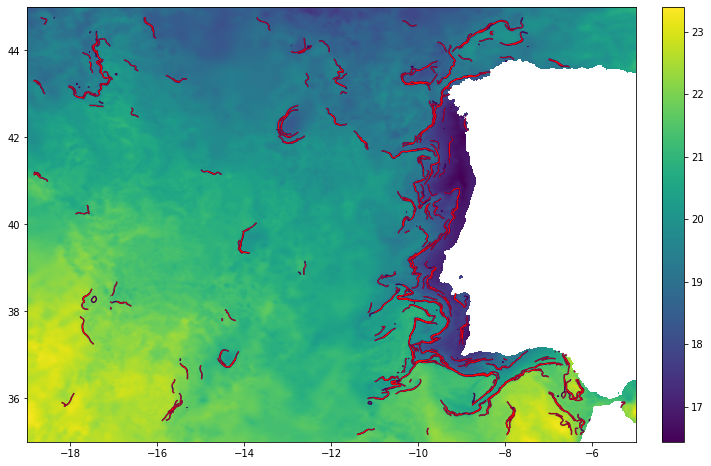

In [33]:
[n_rows, n_cols] = Z.shape       #nr de rows e nr de columns da matriz Z
winW16 = 16
winW32 = 16*2
winW48 = 16*3

                
xmax = X.max()
xmin = X.min()
ymax = Y.max()
ymin = Y.min()
extent = [xmin, xmax, ymin, ymax]   # for visualization in the plt.imshow()

#arrays that will store the contour of every front that will be detected
xdata_final = np.array([])
ydata_final = np.array([])

s=0 #s=1 means subwindows do NOT share a common border. With s = 0 they do.

xSide16 = winW16*head[7]
ySide16 = winW16*head[8]
xSide32 = (winW32 - s) * head[7]
ySide32 = (winW32 - s) * head[8]

nWinRows = math.floor(n_rows/winW16)   #times a window can slide over the rows 
nWinCols = math.floor(n_cols/winW16)   #times a window can slide over the columns


for wRow in range(1, nWinRows-1):    
    #start and stop indices and coords of current window
    r1 = (wRow-1) * winW16 + 1
    r2 = r1 + winW48 -s     
    
    y0 = head[2] + (wRow-1)*ySide16    #y1 = y0 + (winW48-1)*head[8]
    
    for wCol in range(1, nWinCols-1):     
        c1 = (wCol - 1)*winW16+1
        c2 = c1 + winW48 - s
        x0 = head[0] + (wCol-1) * xSide16     #x1 = x0 + (winW48-1)*head[7]
        wPad = Z[r1-1:r2, c1-1:c2]            # 49x49 (or 48x48 if s == 1) Window
        
        rr = np.array([1,1,2,2])
        cc = np.array([1,2,2,1])
        
        if s==1:
            corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
        else:
            corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
        for k in range(0,4):     #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
            m1 = (rr[k] - 1) * winW16 + 1
            m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
            n1 = (cc[k] - 1) * winW16 + 1
            n2 = n1 + 2 * winW16 - s
            
            w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
            #corners coordinates
            subWinX0 = x0 + (cc[k] - 1) * xSide16
            subWinX1 = subWinX0 + xSide32
            subWinY0 = y0 + (rr[k] - 1) * ySide16
            subWinY1 = subWinY0 + ySide32
            
            R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
          
            xdata, ydata, z, exitType = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
            if (exitType == 0):
                   
                xdata_final = np.append(xdata_final, xdata)
                xdata_final = np.append(xdata_final, np.nan)
                
                ydata_final = np.append(ydata_final,ydata)
                ydata_final = np.append(ydata_final, np.nan)
    
        
    
plt.plot(xdata_final, ydata_final, color="red", linewidth=0.5)
plt.imshow(np.flipud(Z), extent=extent)
plt.rcParams["figure.figsize"] = 12, 8
plt.colorbar(fraction=0.036, pad=0.04)
plt.show()
                
               
        

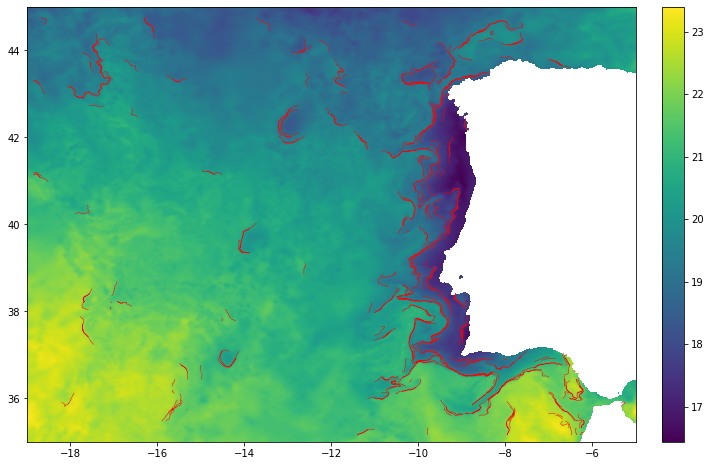

In [39]:
plt.plot(xdata_final, ydata_final, color="red", linewidth=0.5)
plt.imshow(np.flipud(Z), extent=extent)
plt.rcParams["figure.figsize"] = 12, 8
plt.colorbar(fraction=0.036, pad=0.04)
plt.show()

In [48]:
x1 = [1,2,3,4,5,6,7,8,9]
y1 = [10,11,12,13,14,15,16,17,18]
z1 = np.linspace(1,81,81).reshape(9,9).T

In [49]:
z1

array([[ 1., 10., 19., 28., 37., 46., 55., 64., 73.],
       [ 2., 11., 20., 29., 38., 47., 56., 65., 74.],
       [ 3., 12., 21., 30., 39., 48., 57., 66., 75.],
       [ 4., 13., 22., 31., 40., 49., 58., 67., 76.],
       [ 5., 14., 23., 32., 41., 50., 59., 68., 77.],
       [ 6., 15., 24., 33., 42., 51., 60., 69., 78.],
       [ 7., 16., 25., 34., 43., 52., 61., 70., 79.],
       [ 8., 17., 26., 35., 44., 53., 62., 71., 80.],
       [ 9., 18., 27., 36., 45., 54., 63., 72., 81.]])

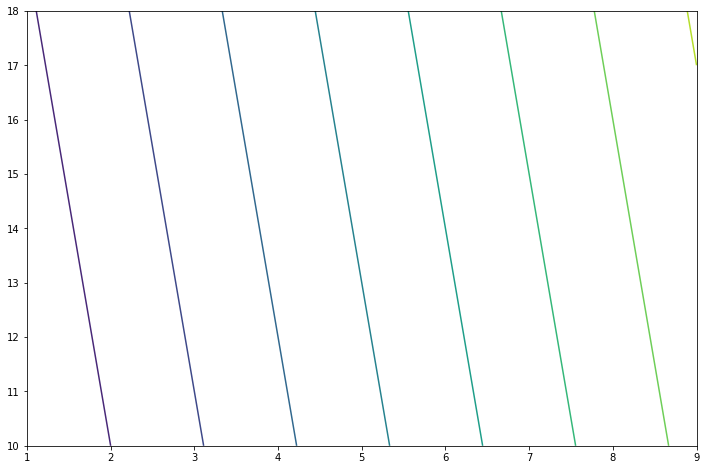

In [50]:
c1 = plt.contour(x1,y1, z1)

In [53]:
M1 = c1.allsegs[:]
M1

[[],
 [array([[ 1.11111111, 18.        ],
         [ 1.22222222, 17.        ],
         [ 1.33333333, 16.        ],
         [ 1.44444444, 15.        ],
         [ 1.55555556, 14.        ],
         [ 1.66666667, 13.        ],
         [ 1.77777778, 12.        ],
         [ 1.88888889, 11.        ],
         [ 2.        , 10.        ]])],
 [array([[ 2.22222222, 18.        ],
         [ 2.33333333, 17.        ],
         [ 2.44444444, 16.        ],
         [ 2.55555556, 15.        ],
         [ 2.66666667, 14.        ],
         [ 2.77777778, 13.        ],
         [ 2.88888889, 12.        ],
         [ 3.        , 11.        ],
         [ 3.11111111, 10.        ]])],
 [array([[ 3.33333333, 18.        ],
         [ 3.44444444, 17.        ],
         [ 3.55555556, 16.        ],
         [ 3.66666667, 15.        ],
         [ 3.77777778, 14.        ],
         [ 3.88888889, 13.        ],
         [ 4.        , 12.        ],
         [ 4.11111111, 11.        ],
         [ 4.22222222, 10. 

In [54]:
#No caso deste contour a lista de arrays tinha listas vazias (que é algo que não queremos)
#Então usamos esta list compreension para dropar os arrays que estão vazios
M1 = [x for x in M1 if x]

In [55]:
#Criar lista com booleans (True or False) conforme as condições em baixo são cumpridas
# é necessário que cada array (linha do contour) tenha mais de 7 elementos e não sejam closed lines
lista1 = []
for i in range(len(M1[:])):
    lista1.append([(len(x)<7 or (x[0][0]==x[-1][0] and x[0][1] == x[-1][1])) for x in M1[:][i]])

In [56]:
lista1
#a lista x tem 10 elementos para aquele contour em questão
#eu tenho de iterar por cada um desses elementos (que é uma lista com um boolean (True or False))



#se for false essa linha sera desenhada
#se for True essa linha será ignorada

#Para desenharmos a linha vamos ter de guardar os seus dados (pontos na variavel x data e ydata)

[[False], [False], [False], [False], [False], [False], [False], [True]]

In [57]:
xdata = np.array([])
ydata = np.array([])
count=0

for value in lista1:
    
    if value == [True]:
        continue
    else:
        
        
    #Para o primeiro array de M vamos sacar todos os valores de x e coloca-los num array
        x = []
        for i in range(len(M1[:][count][0])):
            x.append((M1[:][count][0][i][0]).round(4))
                
    #Para o primeiro array de M vamos sacar todos os valores de y e coloca-los num array
        y = []
        for i in range(len(M1[:][count][0])):
            y.append((M1[:][count][0][i][1]).round(4))
            
        
        xdata = np.append(xdata, x)
        ydata = np.append(ydata, y)
        
        xdata = np.append(xdata, np.nan)
        ydata = np.append(ydata, np.nan)
            
        
        #if (len(xdata) == 0):
         #   xdata = x    #first contour
          #  ydata = y
        #else:
         #   xdata.append(x)
          #  ydata.append(y)
            #xdata = [xdata, np.nan, x]
            #ydata = [ydata, np.nan, y]
        
        count=count+1

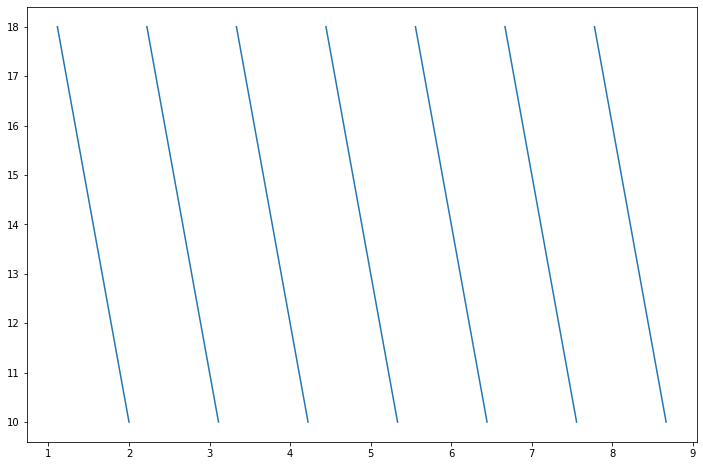

In [58]:
h = plt.plot(xdata, ydata)